In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data=pd.read_csv('apple15.csv', index_col=['date'], parse_dates=['date'])

In [12]:
data.head(10)

,open,high,low,close,Volume
date,,,,,
2017-07-07,142.90,144.75,142.90,144.18,19201712
2017-07-06,143.02,143.50,142.41,142.73,24128782
2017-07-05,143.69,144.79,142.72,144.09,21569557
2017-07-03,144.88,145.30,143.10,143.50,14277848
2017-06-30,144.45,144.96,143.78,144.02,23024107
2017-06-29,144.71,145.13,142.28,143.68,31499368
2017-06-28,144.49,146.11,143.16,145.83,22082432
2017-06-27,145.01,146.16,143.62,143.73,24761891
2017-06-26,147.17,148.28,145.38,145.82,25692361


In [7]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error


In [9]:
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [10]:
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [13]:
from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Autocorrelation

Informally, **autocorrelation** is the similarity between observations as a function of the time lag between them.
The autocorrelation plot which looks like sinusoidal function is a hint for seasonality.


## Seasonality

**Seasonality** refers to periodic fluctuations

Remember that seasonality can also be derived from an autocorrelation plot if it has a sinusoidal shape. Simply look at the period, and it gives the length of the season.

## Stationarity

**Stationarity** is an important characteristic of time series. A time series is said to be stationary if its statistical properties do not change over time. In other words, it has **constant mean and variance**, and covariance is independent of time.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

Ideally, we want to have a stationary time series for modelling. Of course, not all of them are stationary, but we can make different transformations to make them stationary.

### How to test if a process is stationary

*Dickey-Fuller* is the statistical test that we run to determine if a time series is stationary or not.

Without going into the technicalities of the Dickey-Fuller test, it test the null hypothesis that a unit root is present.

If it is, then p > 0, and the process is not stationary.

Otherwise, p = 0, the null hypothesis is rejected, and the process is considered to be stationary.

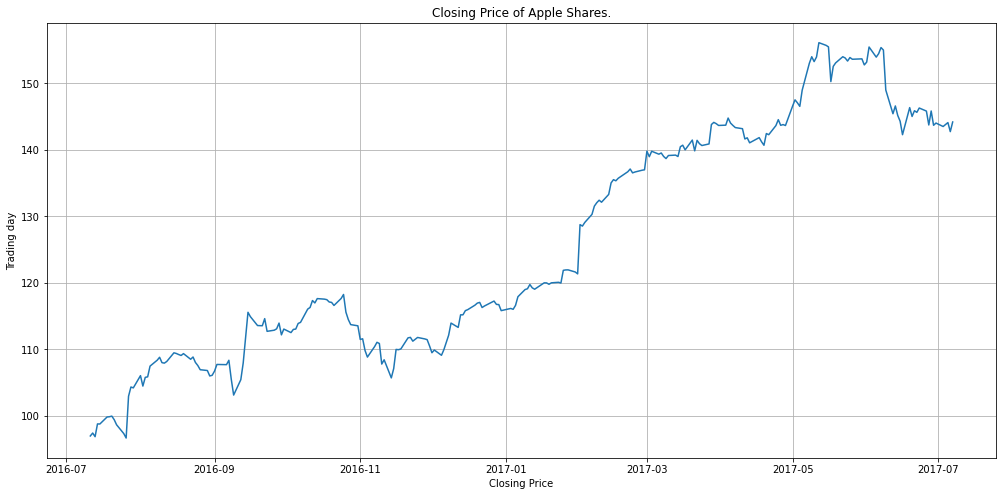

In [14]:
plt.figure(figsize=(17,8))
plt.plot(data.close)
plt.title('Closing Price of Apple Shares.')
plt.xlabel('Closing Price')
plt.ylabel('Trading day')
plt.grid(True)
plt.show()

Clearly, you see that this is not a stationary process, and it is hard to tell if there is some kind of seasonality.
(Seasonality refers to periodic fluctuations)

### Modelling time series

There are many ways to model a time series in order to make predictions. Here, I will present:

   - moving average
   - exponential smoothing
   - ARIMA

#### Moving average


The moving average model is probably the most naive approach to time series modelling. This model simply states that the next observation is the mean of all past observations.

Although simple, this model might be surprisingly good and it represents a good starting point.

Otherwise, the moving average can be used to identify interesting trends in the data. We can define a *window* to apply the moving average model to smooth the time series, and highlight different trends.

*The longer the window, the smoother the trend will be*

#### Exponential smoothing

Exponential smoothing uses a similar logic to moving average, but this time, a different *decreasing weight* is assigned to each observations. In other words, *less importance* is given to observations as we move further from the present.

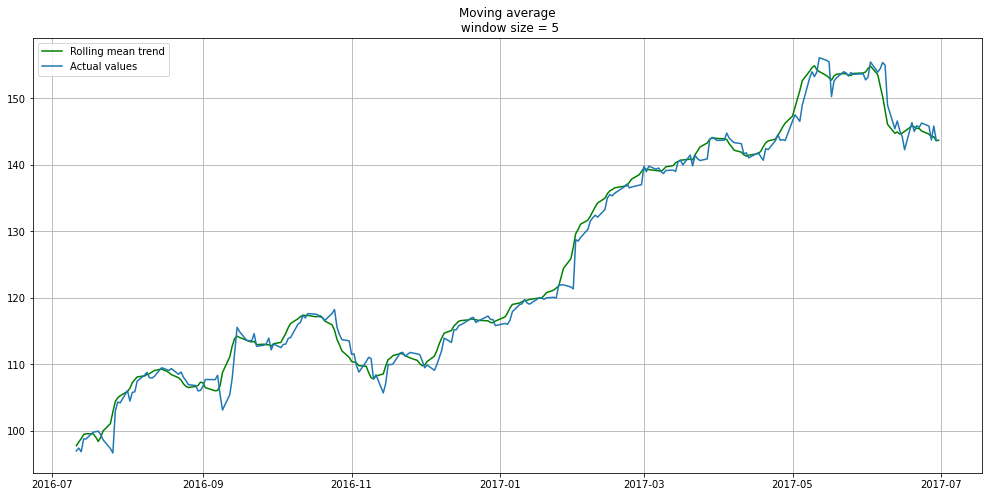

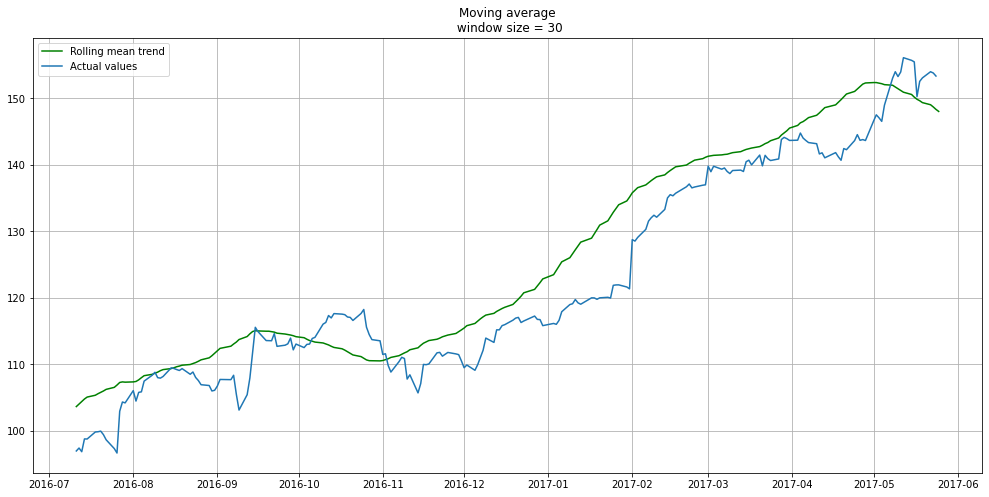

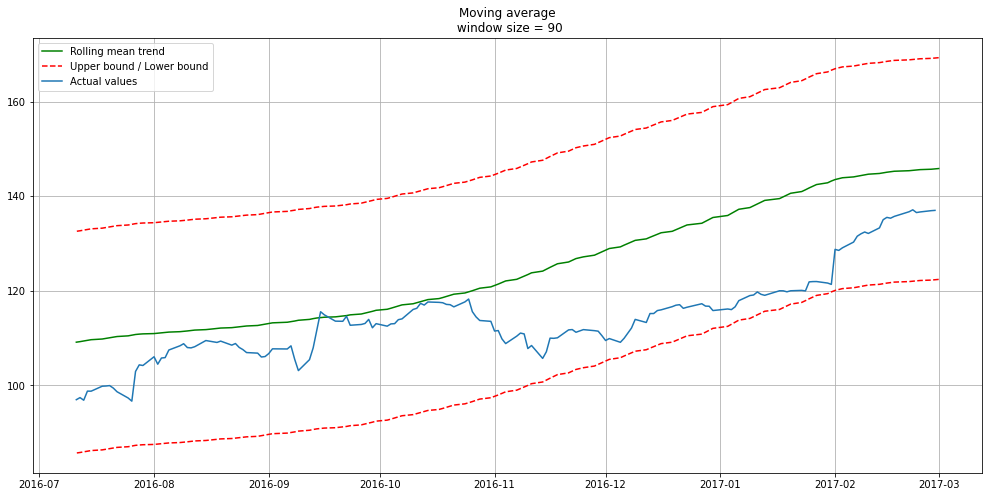

In [15]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data.close, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.close, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.close, 90, plot_intervals=True)

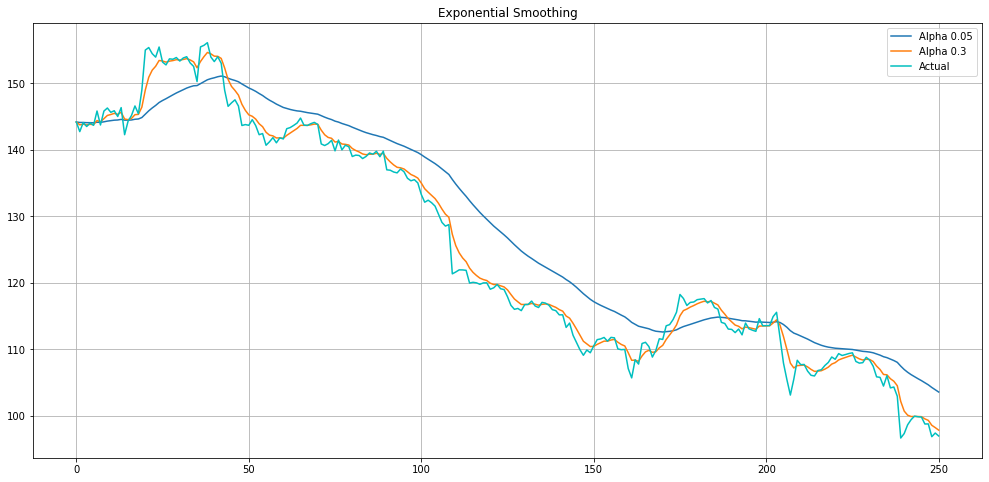

In [19]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.close, [0.05, 0.3])

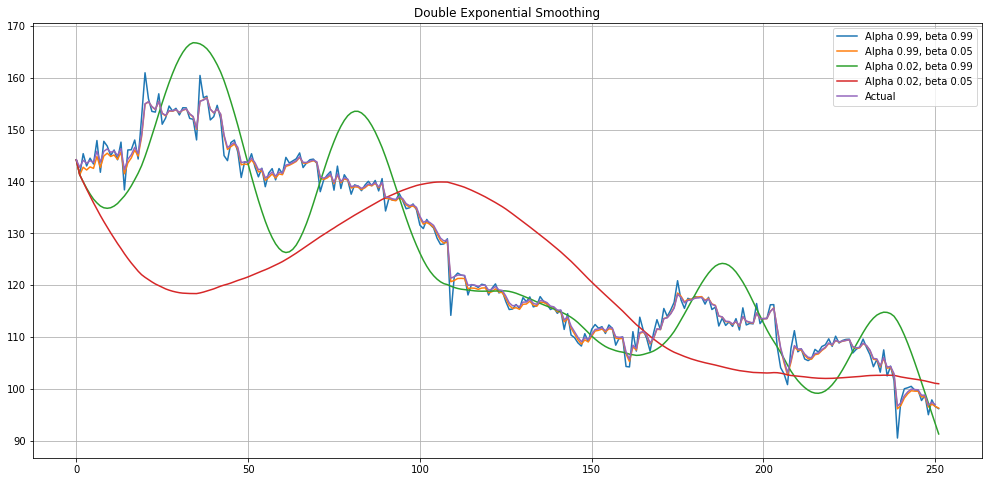

In [23]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data.close, alphas=[0.99, 0.02], betas=[0.99, 0.05])

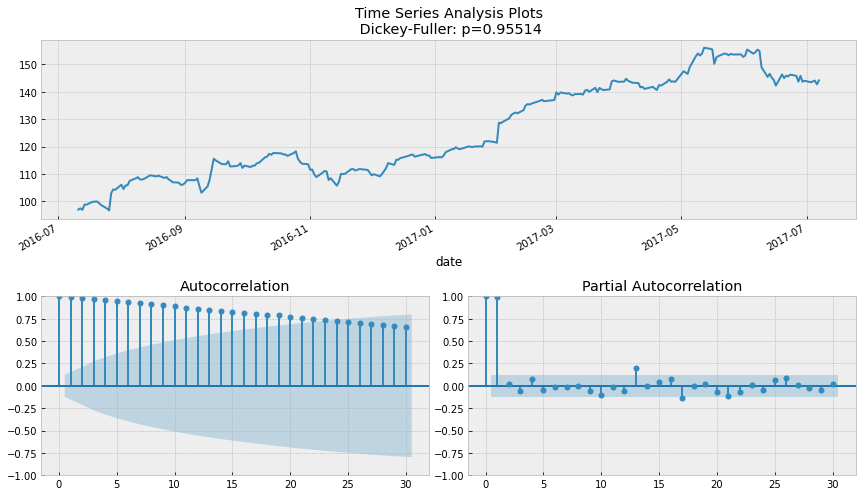

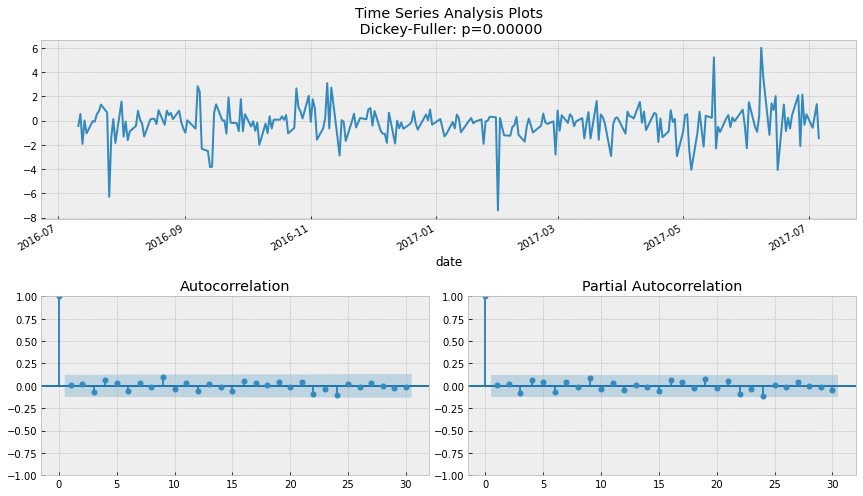

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.close, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.close - data.close.shift(1)

tsplot(data_diff[1:], lags=30)

In [27]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                  251
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 5)   Log Likelihood                -443.185
Date:                             Sat, 27 Nov 2021   AIC                            890.371
Time:                                     22:07:09   BIC                            897.373
Sample:                                          0   HQIC                           893.191
                                             - 251                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L5       -0.9994      2.702     -0.370      0.711      -6.296       4.297
sigma2         2.0152      